In [154]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [155]:
db_path = 'concerts.db'
conn = sqlite3.connect(db_path)

In [156]:
db_table_names = ('artist', 'customer', 'genre', 'performance', 'ticket', 'ticketpricing')
table_df_dict = dict()

for table_name in db_table_names:
    table_df_dict[table_name] = pd.read_sql_query(f'SELECT * FROM {table_name}', conn)

In [157]:
df = pd.DataFrame()

In [158]:
def populate_with_data(df):
    df['Ticket Price'] = table_df_dict['ticket']['ticketPrice']
    df['Ticket Category'] = table_df_dict['ticket']['type']

    merged_df = pd.merge(table_df_dict['artist'], table_df_dict['genre'], on='idGenre', how='left')
    merged_df = pd.merge(table_df_dict['performance'], merged_df, on='idArtist', how='left')
    merged_df = pd.merge(table_df_dict['ticket'], merged_df, on='idPerformance', how='left')

    df['Artist'] = merged_df['name_x']
    df['Genre'] = merged_df['genreName']
    df['Performance Name'] = merged_df['name_y']
    df['Performance Date'] = merged_df['date']

    df['Official Ticket Price'] = table_df_dict['ticket'].merge(
        table_df_dict['ticketpricing'][['idPerformance', 'Type', 'price']],
        left_on=['idPerformance', 'type'],
        right_on=['idPerformance', 'Type'],
        how='left'
    )['price']

In [159]:
populate_with_data(df)
df = df.drop('Official Ticket Price', axis=1)

In [160]:
df.head()

,Ticket Price,Ticket Category,Artist,Genre,Performance Name,Performance Date
0,2000,A,ABX,Pop,ABBA,2025-06-18 20:30:00
1,900,C,Adelaire,Pop,Adele,2025-06-19 20:30:00
2,200,D,BamaBeats,Country,Alabama,2025-06-20 20:30:00
3,1000,B,ChillSync,Rock,Coldplay,2025-06-21 20:30:00
4,900,A,Distorto,Metal,Disturbed,2025-06-25 21:30:00


In [161]:
X_train = df.drop('Ticket Price', axis=1).iloc[0:24]
X_test = df.drop('Ticket Price', axis=1).iloc[24:30]
y_train = df['Ticket Price'].iloc[0:24]
y_test = df['Ticket Price'].iloc[24:30]

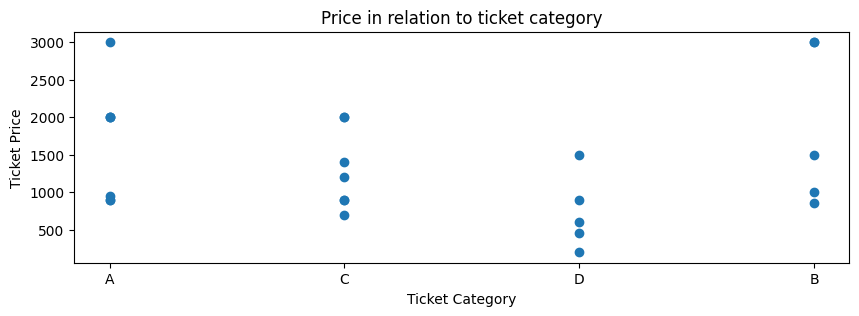

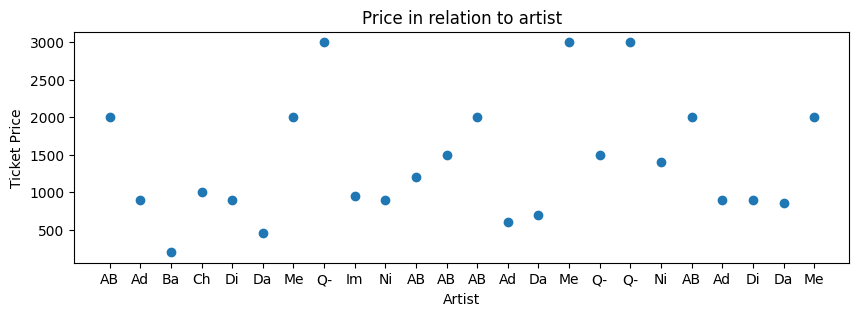

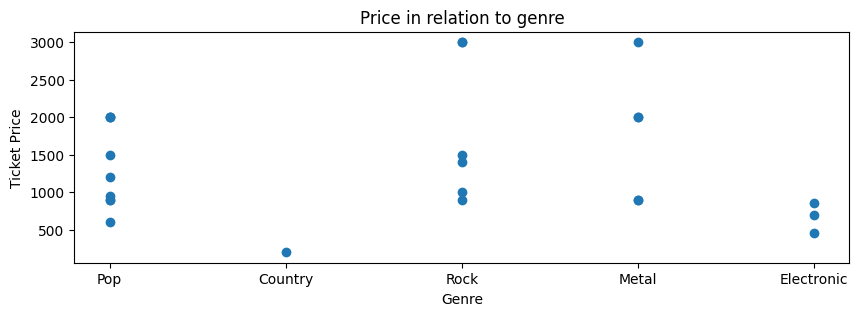

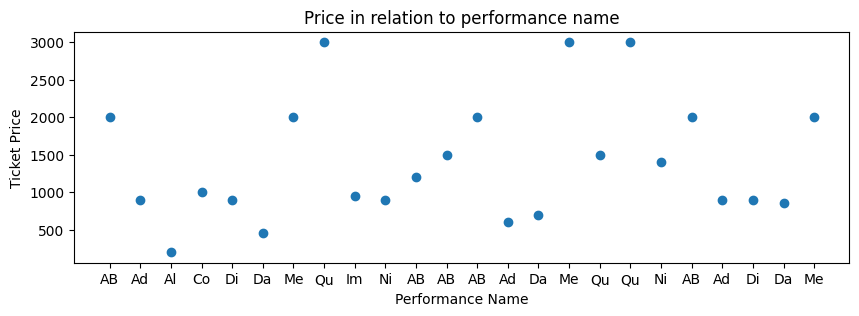

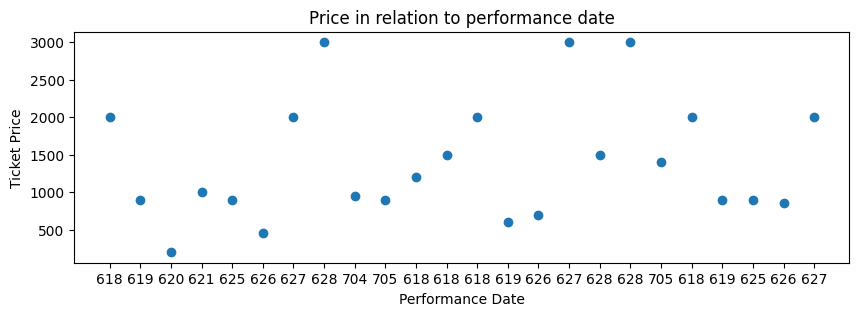

In [162]:
for column in X_train.columns:
    plt.figure(figsize=(10, 3))
    
    if column in ('Artist', 'Performance Name', 'Performance Date'):
        if column == 'Performance Date':
            short_labels = X_train[column].str[6:7] + X_train[column].str[8:10]
        else:
            short_labels = X_train[column].str[:2]
        
        x_positions = range(len(X_train[column]))
        
        plt.scatter(x_positions, y_train)
        plt.xticks(ticks=x_positions, labels=short_labels)
    else:
        plt.scatter(X_train[column], y_train)
    
    plt.title(f'Price in relation to {column.lower()}')
    plt.xlabel(f'{column}')
    plt.ylabel('Ticket Price')
    
    plt.show()

In [163]:
df['Month'] = df['Performance Date'].str[5:7].astype(int)
df['Day'] = df['Performance Date'].str[8:10].astype(int)
df['Hour'] = df['Performance Date'].str[11:13].astype(int)
df['Minute'] = df['Performance Date'].str[14:16].astype(int)

In [164]:
date_map = {'Month': 12, 'Day': 30, 'Hour': 24, 'Minute': 60}

for column, count in date_map.items():
    if column in ('Month', 'Day'):
        adjust = 1
    else:
        adjust = 0
    df[f'{column} Sin'] = np.sin((df[column]-adjust) * (2.*np.pi/count))
    df[f'{column} Cos'] = np.cos((df[column]-adjust) * (2.*np.pi/count))

In [165]:
df_date_encd = df.drop(['Performance Date', 'Month', 'Day', 'Hour', 'Minute'], axis=1)
df_date_encd.head()

,Ticket Price,Ticket Category,Artist,Genre,Performance Name,Month Sin,Month Cos,Day Sin,Day Cos,Hour Sin,Hour Cos,Minute Sin,Minute Cos
0,2000,A,ABX,Pop,ABBA,0.5,-0.866025,-0.406737,-0.913545,-0.866025,0.500000,1.224647e-16,-1.0
1,900,C,Adelaire,Pop,Adele,0.5,-0.866025,-0.587785,-0.809017,-0.866025,0.500000,1.224647e-16,-1.0
2,200,D,BamaBeats,Country,Alabama,0.5,-0.866025,-0.743145,-0.669131,-0.866025,0.500000,1.224647e-16,-1.0
3,1000,B,ChillSync,Rock,Coldplay,0.5,-0.866025,-0.866025,-0.500000,-0.866025,0.500000,1.224647e-16,-1.0
4,900,A,Distorto,Metal,Disturbed,0.5,-0.866025,-0.951057,0.309017,-0.707107,0.707107,1.224647e-16,-1.0


In [166]:
# one-hot encoding for ticket category, artist, genre, performance name column

one_hot_enc = OneHotEncoder()

categorical_cols = ['Ticket Category', 'Artist', 'Genre', 'Performance Name']
numerical_cols = [] # add numerical columns for scaling

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

# regressor = Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     # regression model
# ])

# regressor.fit(X_train, y_train)
